# Second Foundation Analytical Problem - Yi Zhang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from xgboost import XGBClassifier
from statsmodels.graphics.tsaplots import plot_acf

# 1. Load Data and Data Quanlity Check

In [2]:
# Load Data
data = pd.read_csv("data.csv")

In [3]:
# Time series data converting
df = data.copy()
df['utc'] = pd.to_datetime(df['utc'], utc=True)
df = df.sort_values('utc').reset_index(drop=True)

In [4]:
# Check Data Completeness and Duplicates
print("shape:", df.shape)
print(df.dtypes)
print("nulls:\n", df.isna().sum())
print("duplicates:", df.duplicated(subset=['utc']).sum())

shape: (594293, 2)
utc    datetime64[ns, UTC]
val                float64
dtype: object
nulls:
 utc    0
val    0
dtype: int64
duplicates: 0


# 2. EDA

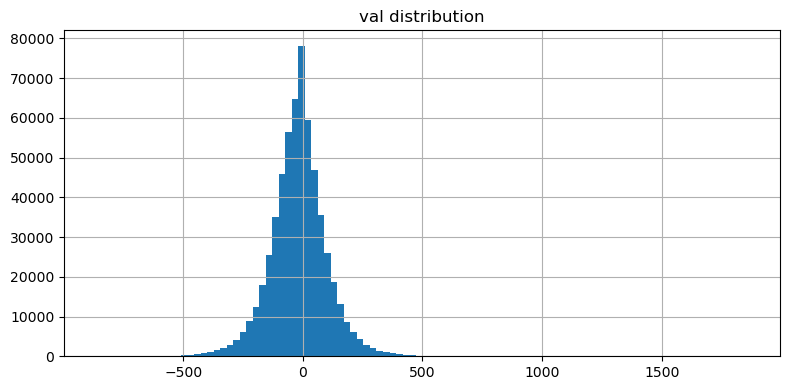

In [5]:
# Distribution of Val
df['val'].hist(bins=100, figsize=(8,4))
plt.title("val distribution")
plt.tight_layout()
plt.show()

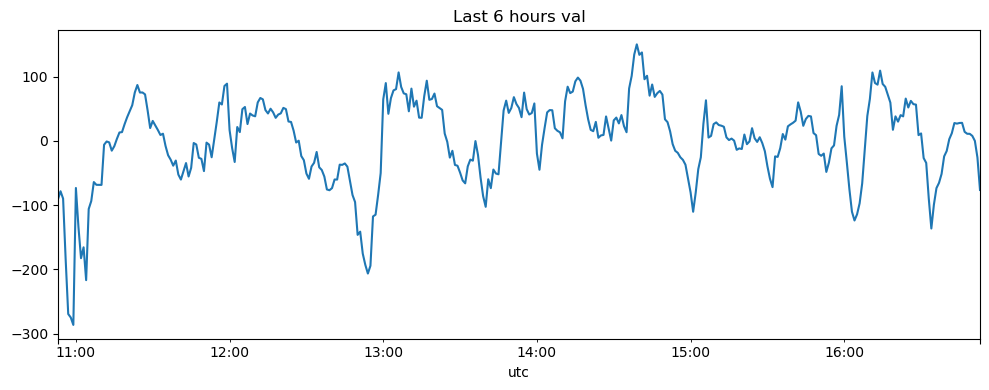

In [6]:
# Last 6 hour Val Plot
end_time = df['utc'].max().floor('min')
start_time = end_time - pd.Timedelta(hours=6)
df[(df['utc']>=start_time) & (df['utc']<=end_time)].set_index('utc')['val'].plot(figsize=(10,4))
plt.title("Last 6 hours val")
plt.tight_layout()
plt.show()

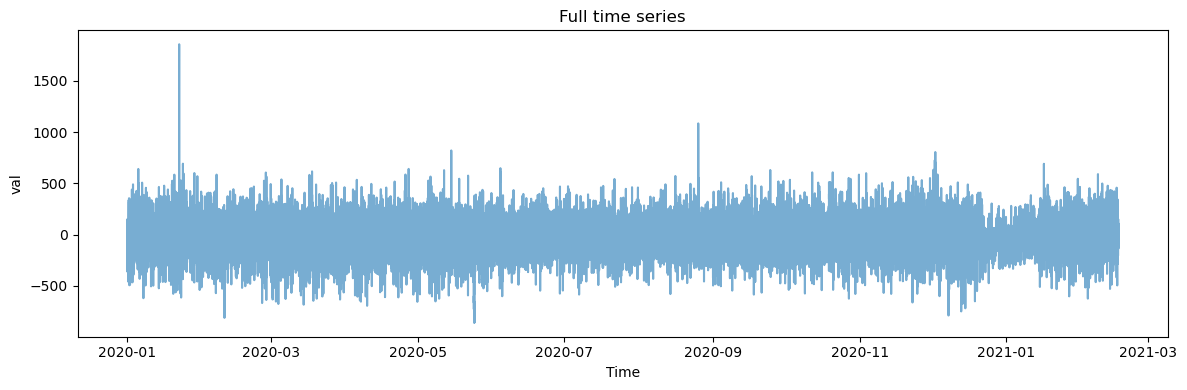

In [7]:
#Full time series plot
plt.figure(figsize=(12,4))
plt.plot(df['utc'], df['val'], alpha=0.6)
plt.title("Full time series")
plt.xlabel("Time")
plt.ylabel("val")
plt.tight_layout()
plt.show()

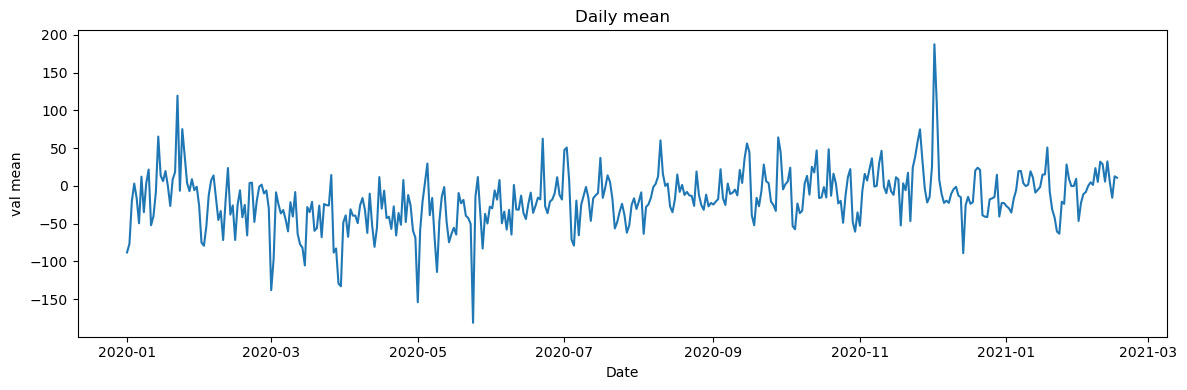

In [8]:
# Daily Generation
daily = df.set_index('utc')['val'].resample('D').mean()
plt.figure(figsize=(12,4))
plt.plot(daily.index, daily.values)
plt.title("Daily mean")
plt.xlabel("Date")
plt.ylabel("val mean")
plt.tight_layout()
plt.show()


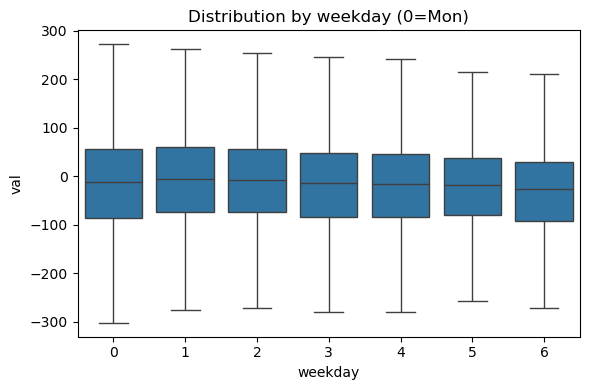

In [9]:
# Weekday distribution
df['weekday'] = df['utc'].dt.weekday
plt.figure(figsize=(6,4))
sns.boxplot(x='weekday', y='val', data=df, showfliers=False)
plt.title("Distribution by weekday (0=Mon)")
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

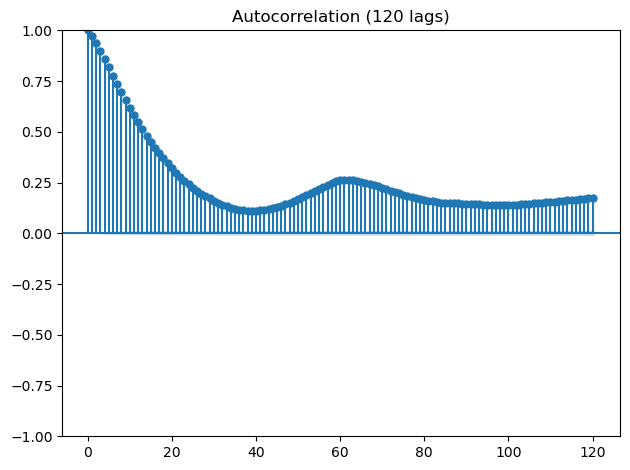

In [10]:
# Autocorrelation (up to 120 lags = 2h)
plt.figure(figsize=(8,4))
plot_acf(df['val'].dropna(), lags=120)
plt.title("Autocorrelation (120 lags)")
plt.tight_layout()
plt.show()

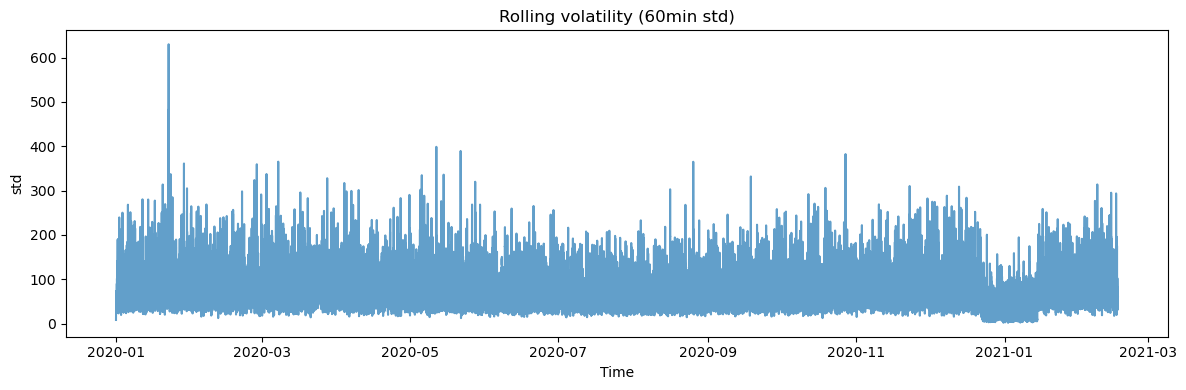

In [11]:
# Rolling volatility (std over 60min)
vol = df.set_index('utc')['val'].rolling('60min').std()
plt.figure(figsize=(12,4))
plt.plot(vol.index, vol.values, alpha=0.7)
plt.title("Rolling volatility (60min std)")
plt.xlabel("Time")
plt.ylabel("std")
plt.tight_layout()
plt.show()


# 3. Classification Problem

### 3.1 Feature Engineering

In [12]:
idx = pd.date_range(df['utc'].min().floor('min'),
                    df['utc'].max().floor('min'),
                    freq='min', tz='UTC')
s = df.set_index('utc')['val'].reindex(idx).astype(float)
s = s.ffill().fillna(0.0)

# Decision at H:54 predicts the sum over [H+1:00, H+2:00)
decisions = s.index[s.index.minute == 54]  # all :54 timestamps
y_list, t0_list, t1_list, tdec_list = [], [], [], []

for t_dec in decisions:
    t0 = (t_dec + pd.Timedelta(minutes=6)).ceil('h')  # start of next hour
    t1 = t0 + pd.Timedelta(hours=1)
    if (t0 in s.index) and (t1 in s.index):
        fut_sum = s.loc[t0:t1 - pd.Timedelta(minutes=1)].sum(skipna=True)
        y = 1 if fut_sum > 0 else 0
        y_list.append(y)
        t0_list.append(t0)
        t1_list.append(t1)
        tdec_list.append(t_dec)

labels = pd.DataFrame({
    'decision_ts': tdec_list,
    'target_start': t0_list,
    'target_end': t1_list,
    'y': y_list
}).reset_index(drop=True)

In [13]:
WIN = [5, 15, 30, 60]  # minutes

# Precompute rolling stats on full series
roll_feats = {}
for w in WIN:
    r = s.rolling(w, min_periods=1)
    roll_feats[f'mean_{w}m'] = r.mean()
    roll_feats[f'std_{w}m']  = r.std()
    roll_feats[f'min_{w}m']  = r.min()
    roll_feats[f'max_{w}m']  = r.max()
    roll_feats[f'sum_{w}m']  = r.sum()

# Sign ratio (positive over nonzero)
pos = (s > 0).astype(float)
nonzero = (s != 0).astype(float)
for w in WIN:
    pos_cnt   = pos.rolling(w, min_periods=1).sum()
    denom_cnt = nonzero.rolling(w, min_periods=1).sum()
    roll_feats[f'sign_ratio_{w}m'] = pos_cnt / denom_cnt.replace(0, np.nan)

# Slope approx: (x_t - x_{t-(w-1)}) / (w-1)
for w in WIN:
    if w > 1:
        roll_feats[f'slope_{w}m'] = (s - s.shift(w-1)) / (w-1)
    else:
        roll_feats[f'slope_{w}m'] = pd.Series(index=s.index, dtype=float)

# Short-term changes
feat_df = pd.DataFrame({'val': s})
feat_df['val_lag1'] = s.shift(1)
feat_df['chg_1m']   = s - s.shift(1)
feat_df['chg_5m']   = s - s.shift(5)

# Merge rolling dict into feat_df
for k, v in roll_feats.items():
    feat_df[k] = v

# Time features from decision_ts
dec_df = pd.DataFrame({'decision_ts': labels['decision_ts']})
dec_df['hour']    = dec_df['decision_ts'].dt.hour + dec_df['decision_ts'].dt.minute/60.0
dec_df['hour_sin'] = np.sin(2*np.pi*dec_df['hour']/24.0)
dec_df['hour_cos'] = np.cos(2*np.pi*dec_df['hour']/24.0)
dec_df['weekday']  = dec_df['decision_ts'].dt.weekday
dec_df['date']     = dec_df['decision_ts'].dt.date

# Extract features at decision timestamps
X_all = feat_df.loc[labels['decision_ts']].reset_index(drop=True)
X_all = pd.concat([dec_df[['decision_ts','date','hour_sin','hour_cos','weekday']], X_all], axis=1)
y_all = labels['y'].to_numpy()

print("Samples:", X_all.shape[0], "| Features:", X_all.shape[1]-2, "| Pos rate:", y_all.mean())

Samples: 9903 | Features: 35 | Pos rate: 0.3978592345753812


### 3.2 Model Training and Evaluation -- XGBoost

In [14]:
# Train: up to 2021-01-31, Val: 2021-02-01~2021-02-07, Test: 2021-02-08~2021-02-16
dates_ts = pd.to_datetime(X_all['decision_ts'])
train_end = pd.to_datetime("2021-01-31 23:59:59+00:00")
val_end   = pd.to_datetime("2021-02-07 23:59:59+00:00")
test_end  = pd.to_datetime("2021-02-16 23:59:59+00:00")

train_mask = (dates_ts <= train_end)
val_mask   = (dates_ts > train_end) & (dates_ts <= val_end)
test_mask  = (dates_ts > val_end) & (dates_ts <= test_end)

feat_cols = [c for c in X_all.columns if c not in ['decision_ts','date']]

X_train, y_train = X_all.loc[train_mask, feat_cols], y_all[train_mask]
X_val,   y_val   = X_all.loc[val_mask,   feat_cols], y_all[val_mask]
X_test,  y_test  = X_all.loc[test_mask,  feat_cols], y_all[test_mask]
dates_test = dates_ts.loc[test_mask]

print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)

Train: (9528, 35) | Val: (168, 35) | Test: (207, 35)


In [15]:
# XGBoost Model 
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.06,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

xgb.fit(X_train, y_train)

# Evaluation helper
def eval_and_print(split_name, y_true, y_pred):
    print(f"\n== {split_name} ==")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    print("Acc:", round(acc, 3), " F1(macro):", round(f1m, 3))

# Train / Val / Test predictions
train_pred = xgb.predict(X_train)
val_pred   = xgb.predict(X_val)
test_pred  = xgb.predict(X_test)

# Print evaluations
eval_and_print("Train", y_train, train_pred)
eval_and_print("Validation", y_val, val_pred)
eval_and_print("Test", y_test, test_pred)

# Last Day Decision
if len(dates_test) > 0:
    last_mask = (dates_test == dates_test.max()).values
    x_last = X_test.loc[last_mask]
    if hasattr(xgb, "predict_proba"):
        p1 = float(xgb.predict_proba(x_last)[:, 1].mean())
    else:
        p1 = float(xgb.predict(x_last).mean())
    print(f"\nLast decision window: {dates_test.max()} | P(y=1)={p1:.3f}")
    if p1 >= 0.6:
        print("Decision: BUY (expect positive sum -> settlement 90)")
    elif p1 <= 0.4:
        print("Decision: SELL (expect negative sum -> settlement 0)")
    else:
        print("Decision: NO-TRADE (uncertain)")


== Train ==
              precision    recall  f1-score   support

           0      0.776     0.858     0.815      5808
           1      0.734     0.613     0.668      3720

    accuracy                          0.762      9528
   macro avg      0.755     0.735     0.741      9528
weighted avg      0.759     0.762     0.757      9528

Confusion matrix:
 [[4981  827]
 [1441 2279]]
Acc: 0.762  F1(macro): 0.741

== Validation ==
              precision    recall  f1-score   support

           0      0.610     0.782     0.685        78
           1      0.750     0.567     0.646        90

    accuracy                          0.667       168
   macro avg      0.680     0.674     0.665       168
weighted avg      0.685     0.667     0.664       168

Confusion matrix:
 [[61 17]
 [39 51]]
Acc: 0.667  F1(macro): 0.665

== Test ==
              precision    recall  f1-score   support

           0      0.519     0.701     0.597        77
           1      0.777     0.615     0.687       13

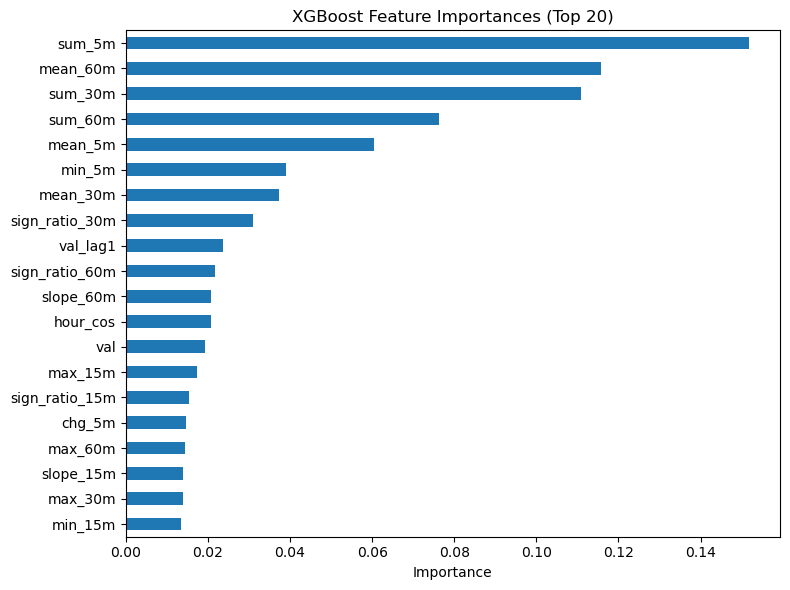

In [16]:
# Feature Importance
feat_names = X_train.columns
imp = pd.Series(xgb.feature_importances_, index=feat_names).sort_values(ascending=False)

topk = 20
imp.head(topk).sort_values().plot(kind="barh", figsize=(8,6))
plt.title("XGBoost Feature Importances (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
